In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
# from transformers import AutoImageProcessor, ResNetForImageClassification,ResNetConfig
import torch
from abc import ABC,abstractmethod

In [2]:
#TODO check if layers are actually being trained
#TODO add more models
#TODO compare metrics
#TODO test out prediction loop
#TODO learn how to use tensorboard

#TODO week2 Balance Dataset
#TODO day2 Implement checkpointing and checkpoint loading
#TODO day2 implement an actually good and modular pipeline
#TODO day2 EDA + explore augments
#TODO day2 normalize and test out mean/median/std of pixel values
#TODO day2 Actually implement additional layers and finish what i started
#TODO Verify data is sent correctly (esp labels)

#TODO day2 implement localization/segmentation + research more abt osteopenia
#interesting models: yolo v5, medsam

###DATASET PREP###

In [3]:
projectPath = r"OsteoBinary"
pathList = []
labelList = []
dirList = os.listdir(projectPath)[:3]
for idx, x in enumerate(dirList):
    for xx in os.listdir(f"{projectPath}/{x}"):
        pathList.append(f"{projectPath}/{x}/{xx}")
        labelList.append(idx)

In [4]:
from PIL import Image
imageSizes = {}
for x in pathList:
    img = Image.open(x).size
    try:
        imageSizes[str(img)] = imageSizes[str(img)] + 1
    except KeyError:
        imageSizes[str(img)] = 1
imageSizes #varied image sizes, have to resize to 1024,1024

{'(525, 1024)': 1,
 '(1040, 2656)': 3,
 '(1056, 2656)': 2,
 '(1128, 2656)': 3,
 '(1036, 2660)': 2,
 '(952, 2656)': 2,
 '(558, 1024)': 1,
 '(528, 1024)': 1,
 '(553, 1024)': 1,
 '(1127, 2660)': 1,
 '(492, 998)': 2,
 '(1312, 2180)': 1,
 '(1088, 2656)': 4,
 '(1149, 2660)': 1,
 '(1096, 2656)': 4,
 '(1076, 2660)': 2,
 '(1032, 2656)': 3,
 '(1040, 2660)': 1,
 '(1144, 2656)': 1,
 '(1095, 2660)': 1,
 '(1113, 2660)': 2,
 '(1008, 2656)': 3,
 '(976, 1972)': 1,
 '(1280, 1896)': 1,
 '(1123, 2656)': 3,
 '(1124, 2660)': 2,
 '(1064, 2656)': 4,
 '(1088, 2280)': 1,
 '(2430, 1994)': 83,
 '(1994, 2430)': 2,
 '(1329, 2180)': 1,
 '(1344, 2520)': 1,
 '(1195, 2656)': 1,
 '(1096, 2659)': 1,
 '(1113, 2656)': 1,
 '(1131, 2656)': 2,
 '(1332, 2180)': 2,
 '(1107, 2656)': 1,
 '(1107, 2659)': 1,
 '(1387, 2179)': 1,
 '(1208, 2296)': 1,
 '(1147, 2656)': 2,
 '(1163, 2656)': 3,
 '(1099, 2656)': 2,
 '(1024, 2656)': 3,
 '(1016, 2656)': 1,
 '(1072, 2480)': 1,
 '(1139, 2659)': 1,
 '(1044, 2660)': 2,
 '(1357, 1992)': 2,
 '(1235

In [5]:
import torchvision
import torch
import torchvision.transforms.functional


class OsteoTorchDataset(torch.utils.data.Dataset):
    def __init__(self, itemsPath:list, labels:list, transform=None, std = False, mean = False): #mean on if mean needs to be scaled, same goes for std
        
        self.itemsPath = itemsPath
        self.labels = labels
        self.transform = transform
        self.std = std
        self.mean = mean

    def __len__(self):
        return len(self.itemsPath)

    def __getitem__(self,idx)->tuple[Image.Image,int]:
        # if torch.is_tensor(idx):
        #     idx = idx.tolist()
        image = Image.open(self.itemsPath[idx]).convert('RGB')
        # image = torchvision.transforms.functional.pil_to_tensor(image)

        if self.transform:
            image = self.transform(image)  
        
        image.to(device = torch.device('cuda'))

        if self.mean or self.std:
            image = self.scaler(image,self.mean,self.std)
        

        return image, self.labels[idx], self.itemsPath[idx]          
    
    def scaler(self,image:torch.tensor,normMean = False,normStd = False): #TODO better way to do this? also huge bottleneck without cuda
        imageSum = torch.sum(image,dim=(1,2))
        mean = imageSum/(image.shape[1]*image.shape[2])
        sum_squared_tensor = torch.sum((imageSum - mean)**2)
        std = torch.sqrt(sum_squared_tensor/image.shape[1]*image.shape[2])

        if not normMean:
            mean = torch.zeros_like(mean,device='cuda')

        if not normStd:
            std = torch.ones_like(std,device='cuda')

        image = torchvision.transforms.functional.normalize(image.float(),mean,std)
        return image
        


transform = torchvision.transforms.Compose([
                                            torchvision.transforms.Resize([244,244]),
                                            torchvision.transforms.ToTensor()
                                            # ,torchvision.transforms.Grayscale()
                                            ])
osteoDataset = OsteoTorchDataset(pathList,labelList,transform,std=True,mean=True)                                  


In [6]:
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import WeightedRandomSampler

osteoDataset = OsteoTorchDataset(pathList,labelList,transform,std=False,mean=False)      
train,val = torch.utils.data.random_split(osteoDataset,[0.8,0.2])#MAY BUG
trainLabels = [y for x,y,z in train]
unique_elements, counts = torch.unique(torch.tensor(trainLabels), return_counts=True)
sampleWeights = 1. / counts.float() #I HAVE NO IDEA WHY THIS WORKS BUT IT DOES
# MORAL OF THE STORY: FOLLOW THE FUCKING TUTORIAL DONT TRY CHANGING SHIT ON YOUR OWN ***EVEN IF THE DOCUMENTATION SAYS YOU SHOULD***
trainSampler = WeightedRandomSampler(weights=[sampleWeights[x] for x in trainLabels],num_samples=len(train),replacement=True)

trainLoader = DataLoader(train, batch_size = 64,shuffle=False,num_workers=0,sampler=trainSampler)
valLoader = DataLoader(val, batch_size = len(val),shuffle=False,num_workers=0)

unique_elements, counts = torch.unique(torch.cat([x for y,x,z in trainLoader]), return_counts=True)#delet this
counts

tensor([144, 154])

In [55]:
unique_elements, counts = torch.unique(torch.cat([x for y,x,z in valLoader]), return_counts=True)#delet this
counts

tensor([38, 36])

In [13]:
temp = next(iter(trainLoader))

tensor(0) OsteoBinary/normal/265n.png
torch.Size([3, 244, 244])


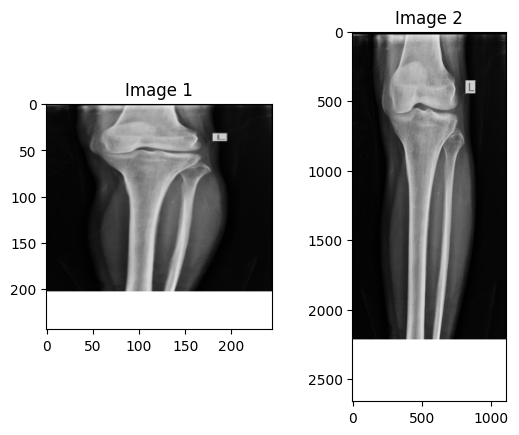

In [14]:
# temp[0][0].min()
import matplotlib.pyplot as plt
index = 0
print(temp[1][index],temp[2][index])
print(temp[0][index].shape)

fig, axs = plt.subplots(1, 2)

# Plot the first image
axs[0].imshow(temp[0][index].permute(1, 2, 0))
axs[0].set_title('Image 1')

# Plot the second image
axs[1].imshow(Image.open(temp[2][index]).convert('RGB'))
axs[1].set_title('Image 2')

plt.show()

In [ ]:
# import models here
from models import AlexNet,resnetWrapper
from resnetModel import ResNet50
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint
from torcheval.metrics.functional import multiclass_f1_score,multiclass_confusion_matrix,multiclass_accuracy
from torchmetrics.classification import MulticlassConfusionMatrix
from matplotlib import pyplot as plt
from torch import mode
import torch.nn.functional as F
import itertools
import seaborn as sns

#FIXME identify bottleneck
#FIXME clean up my fucking code ffs its so UGLY

class ExperimentAlexNet(L.LightningModule):

    existingModels = []

    def __init__(self,pretrainedModel,resize = False,num_class = 3) -> None:
        ExperimentAlexNet.existingModels.append(self)
        super().__init__()
        self.model = pretrainedModel
        self.num_class = num_class
        self.criterion = torch.nn.CrossEntropyLoss()

        # self.resize = resize
        # if self.resize:
        #     self.linear1 = torch.nn.Linear(1000,256)
        #     self.relu1= torch.nn.ReLU()
        #     self.linear2 = torch.nn.Linear(256,3)

        self.valLog = []
        self.epoch = []
        self.valPreds = []
        self.valLabels = []
        self.valScore = []

        self.bestValPreds = [[]]
        self.bestValLabels = [[]]
        self.bestValScore = []

        self.dump = []
        
    def forward(self,input):
        out = self.model(input)
        # if self.resize:
        #     out = self.linear1(out)
        #     out = self.linear2(out)
        return out
        
    def training_step(self,batch):
        data,label,path = batch

        output = self(data)
        # print('\n train pred vs label')
        # print(output.argmax(1))
        # print(data[0])
        # print(label[0])
        self.dump.append([path,label])
        loss = self.criterion(output,label)
        # print(loss)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx) -> None:
        data,label,path = batch
        output = self(data)

        preds = output.argmax(1)
        f1 = multiclass_f1_score(preds,label,num_classes=self.num_class,average = 'macro')
        # print('\npred vs label')
        # print(preds)
        # print(label)
        # print(f'f1:{f1}')
        loss = F.cross_entropy(output,label)
        self.valLabels.append(label)
        self.valPreds.append(output)
        self.valScore.append(multiclass_f1_score(preds,label,num_classes=self.num_class,average = 'macro'))
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_acc_F1", multiclass_f1_score(preds,label,num_classes=self.num_class,average = 'macro'), on_step=False, on_epoch=True, prog_bar=True, logger=True,)
        self.log("val_acc", multiclass_accuracy(preds,label,num_classes=self.num_class), on_step=False, on_epoch=True, prog_bar=True, logger=True)

    
    def on_validation_epoch_end(self) -> None:
        if len(self.valScore) == 2:
            return None
        
        accuracy = torch.stack(self.valScore).mean()
        self.bestValScore.append(accuracy)
        self.bestValPreds.append(torch.cat(self.valPreds))
        self.bestValLabels.append(torch.cat(self.valLabels))

        # print(f"\n Validation accuracy: {accuracy}")
        # print(f"bestValScore: {self.bestValScore}")
        
        self.valPreds = []
        self.valLabels = []
        self.valScore = []
        

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=0.001)

    def predict_step(self, batch):
        data,label = batch
        return self(data.float())

# class ResNetCallbacks(L.Callback): #TODO implement callbacks
#     def on_validation_epoch_end(trainer, pl_module):
#         valLog.append(sum(self.cumLog)/len(self.cumlog))

# alexNet = ExperimentAlexNet(AlexNet(num_classes=3))
# resNet = ExperimentAlexNet(ResNet50(num_classes=3))
preResNet = ExperimentAlexNet(ResNet50(num_classes=2),num_class=2)

In [16]:
# import re
# labelProcess = [re.search(r'\/.*\/',x)[0] for x in preResNet.dump[0][0]]
# [x.strip('\/') for x in labelProcess]

In [60]:
import gc
gc.collect()
torch.cuda.empty_cache()

from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from lightning.pytorch.loggers import TensorBoardLogger

early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=50,          # Number of epochs with no improvement after which training will be stopped
    verbose=False,        # Verbosity mode
    mode='min'           # Mode can be 'min', 'max', or 'auto'
)

logger = TensorBoardLogger("tb_logs", name="my_model")


trainer = L.Trainer(max_epochs = 80,accelerator='gpu', devices='auto', precision='16-mixed',callbacks=[early_stopping],logger=logger)
trainer.fit(model=preResNet,train_dataloaders=trainLoader,val_dataloaders=valLoader)


Using 16bit Automatic Mixed Precision (AMP)
c:\Users\assaw\.conda\envs\AI\lib\site-packages\lightning\pytorch\plugins\precision\amp.py:52: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | ResNet           | 23.5 M | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.155    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\assaw\.conda\envs\AI\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

c:\Users\assaw\.conda\envs\AI\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\assaw\.conda\envs\AI\lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 5/5 [00:21<00:00,  0.23it/s, v_num=33, train_loss_step=0.716]

Epoch 1: 100%|██████████| 5/5 [00:25<00:00,  0.20it/s, v_num=33, train_loss_step=0.678, val_loss=0.756, val_acc_F1=0.339, val_acc=0.514, train_loss_epoch=1.050]

Epoch 2: 100%|██████████| 5/5 [00:25<00:00,  0.20it/s, v_num=33, train_loss_step=0.477, val_loss=1.140, val_acc_F1=0.327, val_acc=0.486, train_loss_epoch=1.060]

Epoch 3: 100%|██████████| 5/5 [00:24<00:00,  0.20it/s, v_num=33, train_loss_step=0.535, val_loss=1.510, val_acc_F1=0.327, val_acc=0.486, train_loss_epoch=0.573]

Epoch 4: 100%|██████████| 5/5 [00:24<00:00,  0.20it/s, v_num=33, train_loss_step=0.518, val_loss=1.580, val_acc_F1=0.327, val_acc=0.486, train_loss_epoch=0.537]

Epoch 5: 100%|██████████| 5/5 [00:24<00:00,  0.21it/s, v_num=33, train_loss_step=0.325, val_loss=1.420, val_acc_F1=0.327, val_acc=0.486, train_loss_epoch=0.525]

Epoch 6: 100%|██████████| 5/5 [00:25<00:00,  0.20it/s, v_num=33, train_loss_step=0.393, val_loss=1.550, val_acc_F1=0.327, val_acc=0.486, train_loss_epoch=0.434]

Epoch 7: 100%|██████████| 5/5 [00:25<00:00,  0.20it/s, v_num=33, train_loss_step=0.374, val_loss=1.520, val_acc_F1=0.327, val_acc=0.486, train_loss_epoch=0.389]

Epoch 8: 100%|██████████| 5/5 [00:25<00:00,  0.19it/s, v_num=33, train_loss_step=0.457, val_loss=0.627, val_acc_F1=0.685, val_acc=0.689, train_loss_epoch=0.470]

Epoch 9: 100%|██████████| 5/5 [00:26<00:00,  0.19it/s, v_num=33, train_loss_step=0.379, val_loss=1.160, val_acc_F1=0.592, val_acc=0.595, train_loss_epoch=0.384]

Epoch 10: 100%|██████████| 5/5 [00:26<00:00,  0.19it/s, v_num=33, train_loss_step=0.479, val_loss=0.770, val_acc_F1=0.676, val_acc=0.676, train_loss_epoch=0.434]

Epoch 11: 100%|██████████| 5/5 [00:25<00:00,  0.19it/s, v_num=33, train_loss_step=0.517, val_loss=0.603, val_acc_F1=0.728, val_acc=0.730, train_loss_epoch=0.418]

Epoch 12: 100%|██████████| 5/5 [00:25<00:00,  0.20it/s, v_num=33, train_loss_step=0.453, val_loss=0.848, val_acc_F1=0.675, val_acc=0.676, train_loss_epoch=0.378]

Epoch 13: 100%|██████████| 5/5 [00:24<00:00,  0.21it/s, v_num=33, train_loss_step=0.288, val_loss=1.010, val_acc_F1=0.692, val_acc=0.703, train_loss_epoch=0.356]

Epoch 14: 100%|██████████| 5/5 [00:25<00:00,  0.19it/s, v_num=33, train_loss_step=0.296, val_loss=1.980, val_acc_F1=0.512, val_acc=0.541, train_loss_epoch=0.288]

Epoch 15: 100%|██████████| 5/5 [00:28<00:00,  0.18it/s, v_num=33, train_loss_step=0.414, val_loss=1.590, val_acc_F1=0.356, val_acc=0.500, train_loss_epoch=0.324]

Epoch 16: 100%|██████████| 5/5 [00:25<00:00,  0.19it/s, v_num=33, train_loss_step=0.383, val_loss=3.570, val_acc_F1=0.468, val_acc=0.568, train_loss_epoch=0.396]

Epoch 17: 100%|██████████| 5/5 [00:28<00:00,  0.18it/s, v_num=33, train_loss_step=0.456, val_loss=0.985, val_acc_F1=0.688, val_acc=0.689, train_loss_epoch=0.359]

Epoch 18: 100%|██████████| 5/5 [00:25<00:00,  0.19it/s, v_num=33, train_loss_step=0.169, val_loss=0.754, val_acc_F1=0.674, val_acc=0.676, train_loss_epoch=0.396]

Epoch 19: 100%|██████████| 5/5 [00:25<00:00,  0.20it/s, v_num=33, train_loss_step=0.343, val_loss=1.310, val_acc_F1=0.369, val_acc=0.527, train_loss_epoch=0.336]

Epoch 20: 100%|██████████| 5/5 [00:28<00:00,  0.18it/s, v_num=33, train_loss_step=0.365, val_loss=1.130, val_acc_F1=0.575, val_acc=0.595, train_loss_epoch=0.335]

Epoch 21: 100%|██████████| 5/5 [00:27<00:00,  0.18it/s, v_num=33, train_loss_step=0.218, val_loss=1.260, val_acc_F1=0.552, val_acc=0.581, train_loss_epoch=0.335]

Epoch 22: 100%|██████████| 5/5 [00:25<00:00,  0.20it/s, v_num=33, train_loss_step=0.201, val_loss=2.460, val_acc_F1=0.533, val_acc=0.568, train_loss_epoch=0.344]

Epoch 23: 100%|██████████| 5/5 [00:30<00:00,  0.16it/s, v_num=33, train_loss_step=0.461, val_loss=1.540, val_acc_F1=0.394, val_acc=0.500, train_loss_epoch=0.253]

Epoch 24: 100%|██████████| 5/5 [00:32<00:00,  0.15it/s, v_num=33, train_loss_step=0.287, val_loss=1.370, val_acc_F1=0.676, val_acc=0.689, train_loss_epoch=0.257]

Epoch 25: 100%|██████████| 5/5 [00:27<00:00,  0.18it/s, v_num=33, train_loss_step=0.284, val_loss=7.550, val_acc_F1=0.369, val_acc=0.527, train_loss_epoch=0.290]

Epoch 26: 100%|██████████| 5/5 [00:25<00:00,  0.19it/s, v_num=33, train_loss_step=0.378, val_loss=2.520, val_acc_F1=0.391, val_acc=0.527, train_loss_epoch=0.284]

Epoch 27: 100%|██████████| 5/5 [00:25<00:00,  0.19it/s, v_num=33, train_loss_step=0.211, val_loss=3.840, val_acc_F1=0.410, val_acc=0.527, train_loss_epoch=0.262]

Epoch 28: 100%|██████████| 5/5 [00:27<00:00,  0.19it/s, v_num=33, train_loss_step=0.129, val_loss=1.360, val_acc_F1=0.580, val_acc=0.595, train_loss_epoch=0.204]

Epoch 29: 100%|██████████| 5/5 [00:27<00:00,  0.18it/s, v_num=33, train_loss_step=0.152, val_loss=0.853, val_acc_F1=0.702, val_acc=0.703, train_loss_epoch=0.160]

Epoch 30: 100%|██████████| 5/5 [00:25<00:00,  0.20it/s, v_num=33, train_loss_step=0.138, val_loss=1.310, val_acc_F1=0.703, val_acc=0.703, train_loss_epoch=0.213]

Epoch 31: 100%|██████████| 5/5 [00:25<00:00,  0.20it/s, v_num=33, train_loss_step=0.100, val_loss=1.490, val_acc_F1=0.714, val_acc=0.716, train_loss_epoch=0.167] 

Epoch 32: 100%|██████████| 5/5 [00:25<00:00,  0.19it/s, v_num=33, train_loss_step=0.286, val_loss=1.130, val_acc_F1=0.793, val_acc=0.797, train_loss_epoch=0.222] 

Epoch 33: 100%|██████████| 5/5 [00:24<00:00,  0.20it/s, v_num=33, train_loss_step=0.173, val_loss=2.200, val_acc_F1=0.459, val_acc=0.554, train_loss_epoch=0.192]

Epoch 34: 100%|██████████| 5/5 [00:26<00:00,  0.19it/s, v_num=33, train_loss_step=0.128, val_loss=1.200, val_acc_F1=0.599, val_acc=0.608, train_loss_epoch=0.251]

Epoch 35: 100%|██████████| 5/5 [00:26<00:00,  0.19it/s, v_num=33, train_loss_step=0.0742, val_loss=3.880, val_acc_F1=0.443, val_acc=0.554, train_loss_epoch=0.237]

Epoch 36: 100%|██████████| 5/5 [00:28<00:00,  0.17it/s, v_num=33, train_loss_step=0.0964, val_loss=1.080, val_acc_F1=0.689, val_acc=0.689, train_loss_epoch=0.200]

Epoch 37: 100%|██████████| 5/5 [00:25<00:00,  0.20it/s, v_num=33, train_loss_step=0.0456, val_loss=1.320, val_acc_F1=0.684, val_acc=0.703, train_loss_epoch=0.165]

Epoch 38: 100%|██████████| 5/5 [00:25<00:00,  0.20it/s, v_num=33, train_loss_step=0.131, val_loss=1.120, val_acc_F1=0.702, val_acc=0.703, train_loss_epoch=0.127] 

Epoch 39: 100%|██████████| 5/5 [00:24<00:00,  0.20it/s, v_num=33, train_loss_step=0.0648, val_loss=1.010, val_acc_F1=0.742, val_acc=0.743, train_loss_epoch=0.111]

Epoch 40: 100%|██████████| 5/5 [00:25<00:00,  0.20it/s, v_num=33, train_loss_step=0.107, val_loss=1.650, val_acc_F1=0.651, val_acc=0.662, train_loss_epoch=0.128] 

Epoch 41: 100%|██████████| 5/5 [00:26<00:00,  0.19it/s, v_num=33, train_loss_step=0.361, val_loss=1.730, val_acc_F1=0.603, val_acc=0.635, train_loss_epoch=0.196]

Epoch 42: 100%|██████████| 5/5 [00:26<00:00,  0.19it/s, v_num=33, train_loss_step=0.163, val_loss=1.350, val_acc_F1=0.689, val_acc=0.689, train_loss_epoch=0.219]

Epoch 43: 100%|██████████| 5/5 [00:24<00:00,  0.20it/s, v_num=33, train_loss_step=0.215, val_loss=1.210, val_acc_F1=0.685, val_acc=0.689, train_loss_epoch=0.188]

Epoch 44: 100%|██████████| 5/5 [00:24<00:00,  0.21it/s, v_num=33, train_loss_step=0.0745, val_loss=1.890, val_acc_F1=0.605, val_acc=0.608, train_loss_epoch=0.225]

Epoch 45: 100%|██████████| 5/5 [00:25<00:00,  0.20it/s, v_num=33, train_loss_step=0.0171, val_loss=1.180, val_acc_F1=0.727, val_acc=0.730, train_loss_epoch=0.122]

Epoch 46: 100%|██████████| 5/5 [00:25<00:00,  0.19it/s, v_num=33, train_loss_step=0.0985, val_loss=1.070, val_acc_F1=0.703, val_acc=0.703, train_loss_epoch=0.113]

Epoch 47: 100%|██████████| 5/5 [00:24<00:00,  0.20it/s, v_num=33, train_loss_step=0.168, val_loss=1.630, val_acc_F1=0.608, val_acc=0.622, train_loss_epoch=0.0763] 

Epoch 48: 100%|██████████| 5/5 [00:24<00:00,  0.20it/s, v_num=33, train_loss_step=0.0756, val_loss=1.380, val_acc_F1=0.664, val_acc=0.676, train_loss_epoch=0.109]

Epoch 49: 100%|██████████| 5/5 [00:26<00:00,  0.19it/s, v_num=33, train_loss_step=0.0345, val_loss=1.470, val_acc_F1=0.682, val_acc=0.689, train_loss_epoch=0.0933]

Epoch 50: 100%|██████████| 5/5 [00:28<00:00,  0.18it/s, v_num=33, train_loss_step=0.038, val_loss=1.820, val_acc_F1=0.686, val_acc=0.689, train_loss_epoch=0.0959] 

Epoch 51: 100%|██████████| 5/5 [00:29<00:00,  0.17it/s, v_num=33, train_loss_step=0.0526, val_loss=2.670, val_acc_F1=0.630, val_acc=0.635, train_loss_epoch=0.153]

Epoch 52: 100%|██████████| 5/5 [00:30<00:00,  0.17it/s, v_num=33, train_loss_step=0.133, val_loss=1.410, val_acc_F1=0.699, val_acc=0.703, train_loss_epoch=0.119] 

Epoch 53:  60%|██████    | 3/5 [00:19<00:12,  0.15it/s, v_num=33, train_loss_step=0.0502, val_loss=1.630, val_acc_F1=0.636, val_acc=0.649, train_loss_epoch=0.138]

c:\Users\assaw\.conda\envs\AI\lib\site-packages\lightning\pytorch\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [ ]:
trainer.fit(model=resNet,train_dataloaders=trainLoader,val_dataloaders=valLoader)

In [65]:
for x in valLoader:
    data, label, _ = x
    print(preResNet(data.to(torch.device('cuda'))))
# preResNet()

tensor([[-2.1513e+00,  2.2113e+00],
        [ 2.1855e+00, -2.1754e+00],
        [-2.1548e+00,  2.1073e+00],
        [-1.8296e+00,  1.8940e+00],
        [ 4.1812e+00, -4.9430e+00],
        [-1.0027e+00,  1.0968e+00],
        [-9.6128e-04,  1.0894e-01],
        [ 3.4036e+00, -3.7609e+00],
        [ 6.0032e+00, -7.2735e+00],
        [-2.5755e-01,  3.0718e-01],
        [ 1.4827e+00, -1.3961e+00],
        [ 5.5695e-01, -6.1689e-01],
        [ 4.9369e+00, -5.4869e+00],
        [ 1.4998e+00, -1.8947e+00],
        [-3.4522e+00,  3.5728e+00],
        [-2.1246e+00,  2.1667e+00],
        [ 4.9413e+00, -5.7955e+00],
        [-1.5223e+00,  1.6034e+00],
        [-2.4357e+00,  2.4292e+00],
        [ 1.1998e+00, -1.1823e+00],
        [ 4.5449e+00, -4.8833e+00],
        [-4.1778e-01,  4.8463e-01],
        [-2.0516e+00,  2.1373e+00],
        [ 1.8168e+00, -1.7508e+00],
        [ 4.5191e+00, -5.2153e+00],
        [-4.0296e+00,  4.1184e+00],
        [ 9.4255e-01, -1.6829e+00],
        [-2.9083e+00,  3.002

In [29]:
# raise AssertionError("done")
x = preResNet
print(f"model: {x.model.__class__.__name__}")
print(f"bestValScore: {max([y.item() for y in x.bestValScore])}")
print(f"bestValPreds: {[[y.argmax().item() for y in w] for w in x.bestValPreds]}")
    # print(f"bestValLabels: {x.bestValLabels}")

model: ResNet
bestValScore: 0.7836257219314575
bestValPreds: [[], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [38]:
# x.bestValLabels[1].cpu()
[[y.argmax().item() for y in w] for w in x.bestValPreds][1]

[]

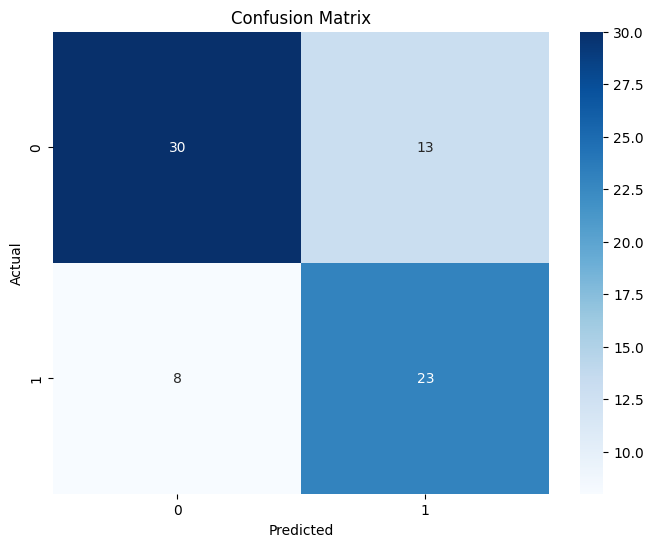

              precision    recall  f1-score   support

           0       0.79      0.70      0.74        43
           1       0.64      0.74      0.69        31

    accuracy                           0.72        74
   macro avg       0.71      0.72      0.71        74
weighted avg       0.73      0.72      0.72        74



In [52]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# [[y.argmax().item() for y in w] for w in x.bestValPreds]
# ([1, 2, 0, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0, 0, 2, 1,
#          1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
# [[y.argmax().item() for y in w] for w in x.bestValPreds]
index = 50
cm = confusion_matrix([[y.argmax().item() for y in w] for w in x.bestValPreds][index], x.bestValLabels[1].cpu())
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
# plt.plot(confusion_matrix([[y.argmax().item() for y in w] for w in x.bestValPreds][index],x.bestValLabels[1].cpu()))
print(classification_report([[y.argmax().item() for y in w] for w in x.bestValPreds][index],x.bestValLabels[1].cpu()))


In [ ]:
for x in [[y.argmax().item() for y in w] for w in x.bestValPreds]:
    print(x)

In [ ]:
evalPred = torch.tensor([[y.argmax().item() for y in w] for w in x.bestValPreds][2]).to('cuda:0')
evalPred

In [ ]:
multiclass_f1_score(evalPred,evalLabels,num_classes=3,average='macro')

In [ ]:
import sklearn
sklearn.metrics.f1_score(evalLabels.cpu(),evalPred.cpu(),average='macro')

In [ ]:
# raise AssertionError("Stop here")
# alex net acc F1 = 0.62 loss = 0.923
# resnet18 acc F1 = ? loss = 1
# resnet50 acc F1 = 0.29 loss = 3
# resnet50 Custom acc F1 = 0.62 loss = 0.957
# resnet50 Custom acc oversampled F1 = 0.78 loss = 0.759
# mobilenet 
# effnet
# Vits 

# model = alexNetNonMod.load_from_checkpoint("/path/to/checkpoint.ckpt")


def testConfMatrix(self) -> None:
        y_hat = torch.tensor([y.argmax() for y in self.bestValPreds]).to('cpu')
        y = self.bestValLabels.to('cpu')

        print(y_hat),print(y)

        confusion_matrix = MulticlassConfusionMatrix(num_classes=3,normalize='true')
        print(confusion_matrix(y_hat, y))

        confusion_matrix_computed = confusion_matrix.compute().detach().cpu().numpy()

        df_cm = pd.DataFrame(confusion_matrix_computed)
        plt.figure(figsize = (10,7))
        fig_ = sns.heatmap(df_cm, annot=True, cmap='Spectral',fmt='g').get_figure()
        plt.show()
       

testConfMatrix(modelList[3])

# early_stopping = EarlyStopping(
#     monitor='val_loss',  # Metric to monitor
#     patience=3,          # Number of epochs with no improvement after which training will be stopped
#     verbose=True,        # Verbosity mode
#     mode='min'           # Mode can be 'min', 'max', or 'auto'
# )

# logger = TensorBoardLogger("tb_logs", name="my_model")
# trainer = L.Trainer(max_epochs = 20,accelerator='gpu', devices='auto', precision='16-mixed',callbacks=[early_stopping],logger=logger)
# trainer.fit(model=alexNetNonMod,train_dataloaders=trainLoader,val_dataloaders=valLoader

In [ ]:
data = []
label = []
valOutput = []
valLabel = []

from itertools import tee
testTrainer =  L.Trainer(accelerator='gpu', devices='auto')
out = testTrainer.predict(alexNet, valLoader)

loader1, loader2 = tee(valLoader) #BUG BUG BUG INCREDIBLY MEMORY INEFFICIENT DONOT RUN THIS ON ANYTHIGN BIGGER THAN 1000 IMAGES

for idx,x in enumerate(valLoader):
    data,label = x
    [valLabel.append(x) for x in label]

valOutput = trainer.predict(alexNet, loader2)

In [ ]:
from resnetModel import ResNet50
model = ResNet50(num_classes=3)

In [ ]:
# from transformers import ViTImageProcessor, ViTForImageClassification
from PIL import Image
# model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')


In [ ]:
from torchvision.models import vgg19


In [ ]:
import torch

import torch.nn as nn
import torch.optim as optim

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Set the device to GPU if available
device = torch.device("cuda")

# Move the model to the device
model = model.to(device)

# Set the model to training mode
model.train()

num_epochs = 50

accHistory = []
lossHistory = []
valAccHistory = []

print("Starting training...")

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_accuracy = []
    
    # Iterate over the training dataset
    for inputs, labels, _ in trainLoader:
        # Move the inputs and labels to the device
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        predicted_labels = torch.argmax(outputs, dim=1)
        accuracy = torch.sum(predicted_labels == labels).item() / labels.size(0)
        running_accuracy.append(accuracy)
        # Compute the loss
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        
        # Update the weights
        optimizer.step()
        
        # Update the running loss
        running_loss += loss.item()
    
    # Print the average loss for the epoch
    print(f"Epoch {epoch+1} - Loss: {running_loss / len(trainLoader)}")
    print(F"Accuracy: {sum(running_accuracy)/len(running_accuracy)}")
    accHistory.append(sum(running_accuracy)/len(running_accuracy))
    lossHistory.append(running_loss / len(trainLoader))

    # Set the model to evaluation mode
    model.eval()

    # Disable gradient calculation
    with torch.no_grad():
        for inputs, labels, _ in valLoader:

            # Move the inputs and labels to the device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Compute the loss
            loss = criterion(outputs, labels)

            # Compute the predicted labels
            predicted_labels = torch.argmax(outputs, dim=1)

            # Compute the accuracy
            accuracy = torch.sum(predicted_labels == labels).item() / labels.size(0)

            valAccHistory.append(accuracy)
            # Print the loss and accuracy
            print(f"Validation Loss: {loss.item()}")
            print(f"Validation Accuracy: {accuracy}")

In [ ]:
input , label, _ = next(iter(valLoader))
# Move the inputs and labels to the device
inputs = inputs.to(device)
labels = labels.to(device)

# Forward pass
outputs = model(inputs)
predicted_labels = torch.argmax(outputs, dim=1)
print(predicted_labels)


In [ ]:
import seaborn as sns
import pandas as pd

# Create a dataframe with the data
df = pd.DataFrame({'Epoch': range(len(accHistory)), 'Accuracy': accHistory, 'Loss': lossHistory, 'Validation Accuracy': valAccHistory})

# Create the line plot
sns.relplot(data=df, x='Epoch', y='Accuracy', kind='line')
sns.relplot(data=df, x='Epoch', y='Loss', kind='line')
sns.relplot(data=df, x='Epoch', y='Validation Accuracy', kind='line')

In [ ]:
torch.save(model.state_dict(), "resnetClassic.pth")


In [ ]:
outputs = []
label = []
import gc
gc.collect()
torch.cuda.empty_cache()
with torch.no_grad():
    for inputs, labels, _ in valLoader:
        # Move the inputs and labels to the device
        inputs = inputs.to(device)
        labels = labels.to(device)
        label = labels
        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Compute the predicted labels
        predicted_labels = torch.argmax(outputs, dim=1)

        # Compute the accuracy
        accuracy = torch.sum(predicted_labels == labels).item() / labels.size(0)

In [ ]:
print(outputs.argmax(1))
print(label)